### Bibliotecas utilizadas

In [125]:
#!pip install hydrobr
import pandas as pd
#!pip install geopandas
import matplotlib.pyplot as plt
import geopandas as gpd

#### Explorando o help da biblioteca hydrobr para acesso aos dados das estações


In [156]:
print(help(hydrobr.get_data.ANA))

Help on class ANA in module hydrobr.get_data:

class ANA(builtins.object)
 |  It provides a connection with the Brazilian National Water Agency (Agência Nacional de Águas - ANA) database
 |  
 |  Static methods defined here:
 |  
 |  flow(list_station, only_consisted=False, threads=10)
 |      Get the flow station data series from a list of stations code of the Brazilian National Water Agency
 |      (ANA) database.
 |      Parameters
 |      ----------
 |      list_station : list of strings
 |          A list of with the stations code as strings.
 |      only_consisted : boolean, default False
 |          If True, returns only the data classified as consistent by the provider.
 |      threads: int
 |          Number of parallel requisitions
 |      Returns
 |      -------
 |      data_stations : pandas DataFrame
 |          The data os each station as a column in a pandas DataFrame
 |  
 |  flow_data(list_station, only_consisted=False)
 |  
 |  list_flow(state='', city='', source='ANA

### Estações meteorológicas em Pernambuco com data final de dados após 1993 

In [26]:
# ----------- Obtendo a lista de todas as estações da ANA
estacoesANA = hydrobr.get_data.ANA.list_prec()

# ---------- Aplicando o filtro para o estado de Pernambuco e com a data final após 1993
estacoesPE = estacoesANA[(estacoesANA['State']=='PERNAMBUCO') &
                        (estacoesANA['EndDate']>"1993/01/01")]

listaEstacoesPE = estacoesPE['Code'].unique()


### Obtendo os dados das estações 

In [ ]:
# # ---------- Criando um df vazio para salvar os dados das estações
# df_estacao_PE = pd.DataFrame()

# for codigo in listaEstacoesPE:
#     # -------- Gravando os dados da estacao em um df
#     df_estacao = hydrobr.get_data.ANA.prec(codigo)
    
#     # -------- Resetando o índice para criar a coluna do periodo
#     df_estacao = df_estacao.reset_index()
    
#     # -------- Salvando o codigo como uma coluna
#     df_estacao['CODIGO'] = codigo
    
#     # ------- Renomeando os campos
#     df_estacao.columns = ['PERIODO', 'PRECIPITACAO', 'CODIGO']
    
#     # ------- Concatenando todos os codigos
#     df_estacao_PE = pd.concat([df_estacao_PE,df_estacao])
# df_estacao_PE.to_csv)r""

### Analisando a completude dos dados 

In [153]:
df_estacao_PE = pd.read_csv(r"G:\.shortcut-targets-by-id\1Ig4Vr9VF8Np7YgZSfkYXz2EJVcGCBP2M\PESQUISA\00_DATASET\02_Precipitação_Gauges\Gauges.csv")

# --------- Removendo a coluna do eixo
df_estacao_PE.drop(['Unnamed: 0'], axis='columns', inplace=True)

# --------- Filtrando o período de janeiro de 1992 a dezembro de 2022
df_estacao_PE = df_estacao_PE[(df_estacao_PE["PERIODO"]>="1992-01-01") &
                              (df_estacao_PE["PERIODO"]<="2022-12-31")].reset_index(drop=True)

# --------- Transformando a coluna de codigo para texto
df_estacao_PE['CODIGO'] = df_estacao_PE['CODIGO'].astype(str)

# ------- Analisando o numero de dados faltantes
percentual_de_dados_faltantes = round((df_estacao_PE['PRECIPITACAO'].isnull().sum()/df_estacao_PE.shape[0])*100, 2)
print("Percentual de dados faltantes: ", percentual_de_dados_faltantes)

# ------- Excluir os dados faltantes
df_estacao_PE.dropna(inplace = True)

#---------- Fazer um merge entre a primeira data e a última data
df_estacao_PE_inicio_e_fim = pd.merge(df_estacao_PE[['CODIGO', 'PERIODO']].drop_duplicates(subset = 'CODIGO', keep = 'first'),
              df_estacao_PE.drop_duplicates(subset = 'CODIGO', keep = 'last'), how = 'inner', on = 'CODIGO')

df_estacao_PE_inicio_e_fim.loc[(df_estacao_PE_inicio_e_fim['PERIODO_x']=='1992-01-01') &
                               (df_estacao_PE_inicio_e_fim['PERIODO_y']=='2022-12-31'), "CLASSIFICAÇÃO"] = 'COMPLETA'
df_estacao_PE_inicio_e_fim.loc[~((df_estacao_PE_inicio_e_fim['PERIODO_x']=='1992-01-01') &
                               (df_estacao_PE_inicio_e_fim['PERIODO_y']=='2022-12-31')), "CLASSIFICAÇÃO"] = 'INCOMPLETA'

df_estacao_PE_inicio_e_fim.columns = ['CODIGO', 'INÍCIO', 'FIM', 'PRECIPITACAO',
       'CLASSIFICAÇÃO']

n_estacoes_completas = len(df_estacao_PE_inicio_e_fim[df_estacao_PE_inicio_e_fim['CLASSIFICAÇÃO']=='COMPLETA']['CODIGO'].unique())
n_estacoes_incompletas = len(df_estacao_PE_inicio_e_fim[df_estacao_PE_inicio_e_fim['CLASSIFICAÇÃO']=='INCOMPLETA']['CODIGO'].unique())

print("Nº de estações completas: ", n_estacoes_completas)
print("Nº de estações incompletas: ", n_estacoes_incompletas)

Percentual de dados faltantes:  5.32
Nº de estações completas:  35
Nº de estações incompletas:  110


#### Utilizando o gráfico de Gantt para analisar a completude dos dados no periodo de janeiro de 1992 até dezembro de 2022 

In [154]:
fig = px.timeline(df_estacao_PE_inicio_e_fim, x_start="INÍCIO", x_end="FIM", y="CODIGO", color="CLASSIFICAÇÃO")
fig.update_yaxes(autorange="reversed")
fig.show()

### Analisando espacialmente a completude dos dados

In [155]:
# --------- importando o shapefile das mesorregiões de Pernambuco
mesorregioes_PE = gpd.read_file(r"C:\Users\flavi\OneDrive - Universidade Federal de Pernambuco\Base de dados\PE 2021\PE_Mesorregioes_2021.shp")

# -------- Padronizando a coluna codigo
df_estacao_PE_inicio_e_fim['CODIGO'] = '00'+df_estacao_PE_inicio_e_fim['CODIGO']

# -------- Fazendo o merge com a latitude e longitude
df_estacao_PE_inicio_e_fim = df_estacao_PE_inicio_e_fim.merge(estacoesPE[['Code', "Latitude", "Longitude" ]], how = 'inner', left_on = 'CODIGO', 
                                right_on = 'Code')


# -------- Transformando as colunas latitude e longitude para o formato geometry
df_estacao_PE_inicio_e_fim = gpd.GeoDataFrame(df_estacao_PE_inicio_e_fim,geometry=gpd.points_from_xy(
    estacoesPE.Longitude,estacoesPE.Latitude))

display(df_estacao_PE_inicio_e_fim.head())

,CODIGO,INÍCIO,FIM,PRECIPITACAO,CLASSIFICAÇÃO,Code,Latitude,Longitude,geometry
0,00735037,1992-01-01,1994-12-31,0.0,INCOMPLETA,00735037,-7.9667,-35.8833,POINT (-35.88330 -7.96670)
1,00735038,1992-01-01,1993-02-28,0.0,INCOMPLETA,00735038,-7.5833,-35.2000,POINT (-35.20000 -7.58330)
2,00735041,1992-01-01,1993-05-31,0.0,INCOMPLETA,00735041,-7.8000,-35.5833,POINT (-35.58330 -7.80000)
3,00735045,1992-01-01,1993-01-31,0.0,INCOMPLETA,00735045,-7.7833,-35.3667,POINT (-35.36670 -7.78330)
4,00735048,1992-01-01,1993-02-28,0.0,INCOMPLETA,00735048,-7.5833,-35.1000,POINT (-35.10000 -7.58330)


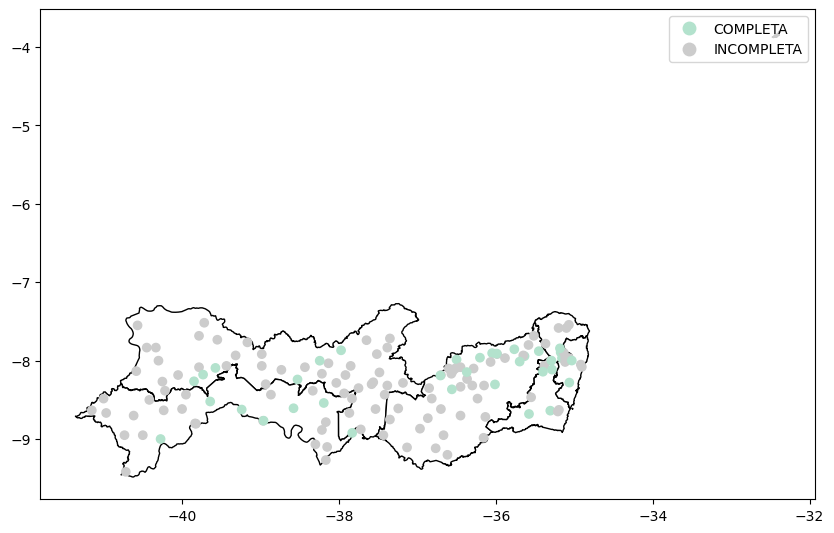

In [151]:
# --------- Plotando estações meteorologicas
fig, ax = plt.subplots(figsize=(10,10))
base = mesorregioes_PE.plot(ax=ax, color = 'white', edgecolor = 'black')
df_estacao_PE_inicio_e_fim.plot(ax=base, column = 'CLASSIFICAÇÃO', legend = True, cmap = 'Pastel2')       
plt.show()